In [24]:
# Import required packages
import concurrent.futures
import ee
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling,transform_bounds
from rasterio.merge import merge
from rasterio.transform import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling,transform_bounds
import restee as ree
from scipy.signal import medfilt2d
import shutil
from skimage.filters import threshold_otsu
from tqdm import tqdm
from zipfile import ZipFile

In [2]:
%run Helper_Functions.ipynb

In [17]:
image_directory = '../../Data'

image_path = '../../Data/16c19b23-9422-4316-a261-d70575dbee32.zip'

output_directory = '../../Results'

tile_directory = '../../Results/Tiles'

pwater_mask_dir = '../../Results/temp_gee_pwater'

slope_mask_dir = '../../Results/temp_gee_slope'

masked_tile_dir = '../../Results/maksed_tiles'

thresold_tile_dir  = '../../Results/temp_thresh_tiles'

flood_product_dir = '../../Results/Flood_product'

df_csv_dir = '../../Results/chip_info'

In [ ]:
#wirte a code to create all the directories at once
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [ ]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
with ZipFile(image_path, 'r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for file_name in listOfFileNames:
        if file_name.endswith('.tif'):
            zipObj.extract(file_name,output_directory)

In [ ]:
img_list = os.listdir('../../Results')
img_list

In [ ]:
img_list = glob.glob('../../Results/*.tif')
img_list

In [ ]:
img_list[1]

In [ ]:
utm_epsg = utm_finder(img_list[1])

In [ ]:
resample(img_list[0],30,output_directory,'hh_resample.tif')
resample(img_list[1],30,output_directory,'hv_resample.tif')

In [ ]:
calibration('../../Results/hh_resample.tif',utm_epsg,output_directory,'hh_calib.tif')

In [ ]:
calibration('../../Results/hv_resample.tif',utm_epsg,output_directory,'hv_calib.tif')

In [ ]:
tile512('/content/img_preprocessed/sigmaN_HH_UTM.tif','/content/img_tiles',"HH")

In [ ]:
tile512('../../Results/hh_calib.tif',tile_directory,'hh')

In [ ]:
tile512('../../Results/hv_calib.tif',tile_directory,'hv')

In [22]:
#remove all the previous results in tif in format
for file in glob.glob(os.path.join(output_directory,'*.tif')):
    os.remove(file)      

In [ ]:
shutil.rmtree("path_to_dir")

In [27]:
for dirc in glob.glob(os.path.join(output_directory,'*')):
    shutil.rmtree(dirc)  

In [6]:
tile_list_hh = glob.glob('../../Results/temp_tiles/*hh.tif')
tile_list_hh.sort()
tile_list_hv = glob.glob('../../Results/temp_tiles/*hv.tif')
tile_list_hv.sort()

df = pd.DataFrame(data =[],columns=['id','HH','HV'])
df['HH'] = tile_list_hh
df['HV'] = tile_list_hv
df['id'] = df.index+1

In [ ]:
# 0-755
random_id = 101

f, ax = plt.subplots(1, 2, figsize=(10, 5))

src_hh = rasterio.open(df['HH'][random_id])
src_hv = rasterio.open(df['HV'][random_id])

ax[0].imshow(src_hh.read(1),cmap='gray')
ax[0].set_title("HH", fontsize=14)
ax[1].imshow(src_hv.read(1),cmap='gray')
ax[1].set_title("HV", fontsize=14)
plt.show()

src_hh.close()
src_hv.close()

In [ ]:
df['HH'][100:106]

In [ ]:
#df.to_csv('../../Results/raster_tiles.csv',index=False)

GEE Integration 

In [ ]:
# cloud project id
PROJECTID = '*****'

In [ ]:
from google.auth.transport.requests import AuthorizedSession

ee.Authenticate()  #  or !earthengine authenticate --auth_mode=gcloud
session = AuthorizedSession(ee.data.get_persistent_credentials())

In [ ]:
# extending a restee session class that works
# with user accounts and auth sessions
# custom EE Session class that accepts an already authorized session
class EESessionContainer(ree.EESession):
    def __init__(self, project, session):
        self._PROJECT = project
        self._SESSION = session

# create an EESesssion object with the correct permissions
ee_session = EESessionContainer(PROJECTID, session)

# authenticate EE with the session credentials
ee.Initialize(ee_session.session.credentials, project=PROJECTID)

In [8]:
pwater_mask_dir = '../../Results/temp_gee_pwater'
slope_mask_dir = '../../Results/temp_gee_slope'

In [ ]:
"""# JRC water
jrc_occ = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')
jrc_occ = jrc_occ.rename('pwater_mask')
pwater_mask = jrc_occ.select('pwater_mask').gt(90).selfMask()

# SRTM improved dem
elevation = ee.Image('NASA/NASADEM_HGT/001').select('elevation')
slope = ee.Terrain.slope(elevation)
slope_mask = slope.lt(5).selfMask().rename('slope_mask')"""

In [ ]:
# JRC water
jrc_occ = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('occurrence')
jrc_occ = jrc_occ.rename('pwater_mask')
pwater_mask = jrc_occ.select('pwater_mask').gt(90).selfMask()

# SRTM improved dem
elevation = ee.Image('CGIAR/SRTM90_V4').select('elevation')
slope = ee.Terrain.slope(elevation)
slope_mask = slope.lt(5).selfMask().rename('slope_mask')

In [ ]:
tile_list = tile_list_hh

In [ ]:
with tqdm(total=len(tile_list),position=0, leave=True, desc="GEE data request progress: JRC Water data") as pbar:     
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor: 
        # Start the load operations and mark each future with its chip        
        future_to_chip = {executor.submit(restgee_data,chip,pwater_mask, 'pwater_mask', pwater_mask_dir): chip for chip in tile_list}          
        for future in concurrent.futures.as_completed(future_to_chip):
            chip = future_to_chip[future]
            pbar.update(n=1)

In [ ]:
with tqdm(total=len(tile_list),position=0, leave=True, desc="GEE data request progress: NASA SRTM data") as pbar:      
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor: 
        # Start the load operations and mark each future with its chip        
        future_to_chip = {executor.submit(restgee_data,chip,slope_mask, 'slope_mask', slope_mask_dir): chip for chip in tile_list}          
        for future in concurrent.futures.as_completed(future_to_chip):
            chip = future_to_chip[future]
            pbar.update(n=1)

In [9]:
tile_list_pwater_mask = glob.glob(os.path.join(pwater_mask_dir,'*'))
tile_list_pwater_mask.sort()
tile_list_slope_mask = glob.glob(os.path.join(slope_mask_dir,'*'))
tile_list_slope_mask.sort()

In [10]:
df['pwater_msk'] = tile_list_pwater_mask
df['slope_msk'] = tile_list_slope_mask

In [ ]:
#df.to_csv('../../Results/raster_tiles.csv',index=False)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


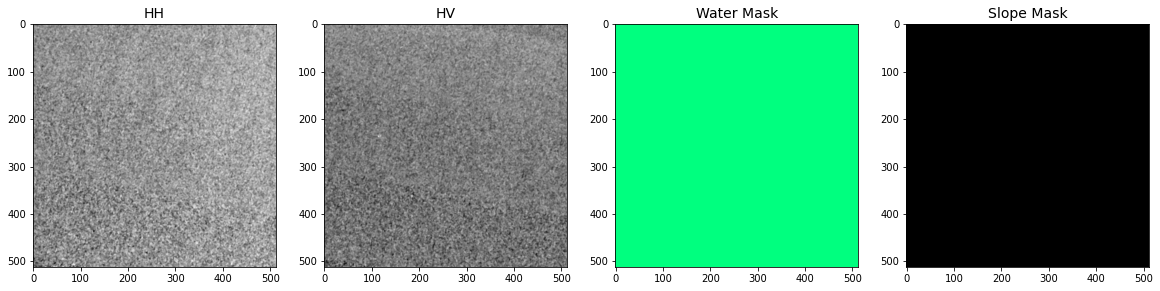

In [14]:
# 0-755
random_id = 720

f, ax = plt.subplots(1, 4, figsize=(20, 6))
src_hh = rasterio.open(df['HH'][random_id])
src_hv = rasterio.open(df['HV'][random_id])
src_slp_msk = rasterio.open(df['slope_msk'][random_id])
src_wat_msk = rasterio.open(df['pwater_msk'][random_id])

print(src_wat_msk.read(1))

ax[0].imshow(src_hh.read(1),cmap='gray')
ax[0].set_title("HH", fontsize=14)
ax[1].imshow(src_hv.read(1),cmap='gray')
ax[1].set_title("HV", fontsize=14)
ax[2].imshow(src_wat_msk.read(1),cmap='winter_r')
ax[2].set_title("Water Mask", fontsize=14)
ax[3].imshow(src_slp_msk.read(1),cmap='copper')
ax[3].set_title("Slope Mask", fontsize=14)

plt.show()

src_hh.close()
src_hv.close()
src_slp_msk.close()
src_wat_msk.close()

In [15]:
df['pwater_msk'][720]

'../../Results/temp_gee_pwater/T2719_pwater_mask.tif'

In [ ]:
# raster tile masking

In [ ]:
masked_tile_dir = '../../Results/maksed_tiles'

In [ ]:
for i in tqdm(range(len(df['HH'])), desc="Data Masking Progress" ):
    pwater_slope_masking(df['HH'][i],df['pwater_msk'][i],df['slope_msk'][i],masked_tile_dir)

In [ ]:
for i in tqdm(range(len(df['HV'])), desc="Data Masking Progress" ):
    pwater_slope_masking(df['HV'][i],df['pwater_msk'][i],df['slope_msk'][i],masked_tile_dir)

In [ ]:
tile_list_mask_hh = glob.glob(os.path.join(masked_tile_dir,'*hh_masked.tif'))
tile_list_mask_hh.sort()
tile_list_mask_hv = glob.glob(os.path.join(masked_tile_dir,'*hv_masked.tif'))
tile_list_mask_hv.sort()

df['masked_hh'] = tile_list_mask_hh
df['masked_hv'] = tile_list_mask_hv

In [ ]:
# 0-755
random_id = 101

f, ax = plt.subplots(1, 4, figsize=(20, 6))
src_hh = rasterio.open(df['HH'][random_id])
src_hv = rasterio.open(df['HV'][random_id])
src_msk_hh = rasterio.open(df['masked_hh'][random_id])
src_msk_hv = rasterio.open(df['masked_hv'][random_id])

ax[0].imshow(src_hh.read(1),cmap='gray')
ax[0].set_title("HH", fontsize=14)
ax[1].imshow(src_hv.read(1),cmap='gray')
ax[1].set_title("HV", fontsize=14)
ax[2].imshow(src_msk_hh.read(1),cmap='gray')
ax[2].set_title("Masked HH", fontsize=14)
ax[3].imshow(src_msk_hv.read(1),cmap='gray')
ax[3].set_title("Masked HV", fontsize=14)

plt.show()

src_hh.close()
src_hv.close()
src_msk_hh.close()
src_msk_hv.close()

In [ ]:
df.to_csv('../../Results/raster_tiles.csv',index=False)

Calculating Statistics of masked hh,hv raster tiles

In [3]:
df = pd.read_csv('../../Results/raster_tiles.csv')

In [4]:
import warnings
warnings.filterwarnings('ignore')

with tqdm(total=len(df),position=0, leave=True, desc="Calculating statistics for HH and HV tiles") as pbar:
    for index, row in df.iterrows():
        src1 = rasterio.open(row['masked_hh'])
        arr_1 = src1.read(1)
        src2 = rasterio.open(row['masked_hv'])
        arr_2 = src2.read(1)
    
        #calculations
        hh_mean = np.nanmean(arr_1)
        hv_mean = np.nanmean(arr_2)   
        hh_std_2nd = 2*(np.nanstd(arr_1))
        hv_std_2nd = 2*(np.nanstd(arr_2))  
        
        df.loc[index,'hh_2ndSTD'] = 2*(np.nanstd(arr_1))
        df.loc[index,'hv_2ndSTD'] = 2*(np.nanstd(arr_2))
        df.loc[index,'nan_percent'] = np.count_nonzero(~np.isnan(arr_1))*100 /arr_1.size
        
        src1.close()
        src2.close()  
        pbar.update(n=1) 
    

Calculating statistics for HH and HV tiles: 100%|██████████| 756/756 [00:28<00:00, 26.14it/s]


In [5]:
df = df[df.nan_percent != 0.0]
df_refined = df.loc[df['nan_percent']>50]

In [ ]:
df_refined_hh = df_refined.sort_values(by=['hh_2ndSTD'],ascending=False).head(10).reset_index().drop(['index'],axis=1)
df_refined_hv = df_refined.sort_values(by=['hv_2ndSTD'],ascending=False).head(10).reset_index().drop(['index'],axis=1)
#df_refined_hh_hv = df_refined.sort_values(by=['hh_2ndSTD','hv_2ndSTD'],ascending=False).head(5).reset_index().drop(['index'],axis=1)

In [ ]:
for index, row in df_refined_hh.iterrows():
    src = rasterio.open(row['masked_hh'])
    band = src.read(1)
    band_filtered = band[~np.isnan(band)]
    otsu = threshold_otsu(band_filtered)
    df_refined_hh.loc[index,'otsu'] = otsu
    src.close()
    
for index, row in df_refined_hv.iterrows():
    src = rasterio.open(row['masked_hv'])
    band = src.read(1)
    band_filtered = band[~np.isnan(band)]
    otsu = threshold_otsu(band_filtered)
    df_refined_hv.loc[index,'otsu'] = otsu
    src.close()   

In [ ]:
df_refined_hh.head()

Threshold caculation based on polarization

In this case HH polarization is used

In [ ]:
thresold_tile_dir  = '../../Results/temp_thresh_tiles'

In [ ]:
#otsu_mean_thresh = df_refined_hh['otsu'].mean()
otsu_median_thresh = df_refined_hh['otsu'].median()

In [ ]:
with tqdm(total=len(df),position=0, leave=True, desc="Binary thresholding progress") as pbar:
    for index, row in df.iterrows():
        with rasterio.open(row['masked_hh']) as dataset:
            kwargs = dataset.meta.copy()
            outfile_bin_filt_path = os.path.join(thresold_tile_dir,os.path.basename(row['masked_hh']).split('_masked.tif')[0]+'_msk_bin_filt.tif')            
            df.loc[index,'masked_bin_filt'] = outfile_bin_filt_path           
            band = dataset.read(1)
            band_bin = band < otsu_median_thresh
            
            #filtering using median filter
            band_bin_filt =  medfilt2d(np.float32(band_bin), kernel_size=3)  
            #band_bin_filt[band_bin_filt==0.0]=np.nan
            with rasterio.open(outfile_bin_filt_path, 'w', **kwargs) as dst_bin_filt:
                dst_bin_filt.write(band_bin_filt, 1)     
            pbar.update(n=1)   

In [ ]:
df.head()

In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(15,5))
#fig.suptitle('Figure title')
subfig_titles = ['HH','HH_bin_filterd']
color_map = ['gray','winter_r']

img_list = np.array([df['HH'][200:205],df['masked_bin_filt'][200:205]])
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(subfig_titles[row])
    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=4)
    for col, ax in enumerate(axs):
        src = rasterio.open(img_list[row][col])
        ax.imshow(src.read(1),cmap=color_map[row])             
        src.close()

#plt.savefig('../../Results/df_refined_hv.png')

In [ ]:
flood_product_dir = '../../Results/Flood_product'

In [ ]:
src_files_to_mosaic = list(df['masked_bin_filt']) 


mosaic, out_trans = merge(src_files_to_mosaic)
'''out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 "crs": utm_epsg,
                 'compress': 'lzw',
                 'dtype':'float32',
                 'nodata':np.nan})'''
out_meta = {'driver': "GTiff",
            'height': mosaic.shape[1],
            'width': mosaic.shape[2],
            'transform': out_trans,
            'crs': utm_epsg,
            'count':1,
            'compress': 'lzw',
            'dtype':'float32',
            'nodata':np.nan}

mosaic = mosaic[0]
mosaic[mosaic==0.0]=np.nan
               
with rasterio.open(os.path.join(flood_product_dir,'flood_layer_hh.tif'), "w", **out_meta) as dest:
    dest.write(mosaic,1)
